In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import do_mpc
import sys
import os

In [58]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [59]:
phi = model.set_variable(var_type='_x', var_name='phi', shape=(3,1))
dphi = model.set_variable(var_type='_x', var_name='dphi', shape=(3,1))
# Two states for the desired (set) motor position:
phi_m_1_set = model.set_variable(var_type='_u', var_name='phi_m_1_set')
phi_m_2_set = model.set_variable(var_type='_u', var_name='phi_m_2_set')
# Two additional states for the true motor position:
phi_1_m = model.set_variable(var_type='_x', var_name='phi_1_m', shape=(1,1))
phi_2_m = model.set_variable(var_type='_x', var_name='phi_2_m', shape=(1,1))

In [60]:
print('phi_1_m={}, with phi_1_m.shape={}'.format(phi_1_m, phi_1_m.shape))
print('dphi={}, with dphi.shape={}'.format(dphi, dphi.shape))
print(model.x['phi',0])
model.x.labels()

phi_1_m=phi_1_m, with phi_1_m.shape=(1, 1)
dphi=[dphi_0, dphi_1, dphi_2], with dphi.shape=(3, 1)
phi_0


['[phi,0]',
 '[phi,1]',
 '[phi,2]',
 '[dphi,0]',
 '[dphi,1]',
 '[dphi,2]',
 '[phi_1_m,0]',
 '[phi_2_m,0]']

In [61]:
# As shown in the table above, we can use Long names or short names for the variable type.
# Inertia of the motor(1,2,3):
Theta_1 = model.set_variable('parameter', 'Theta_1')
Theta_2 = model.set_variable('parameter', 'Theta_2')
Theta_3 = model.set_variable('parameter', 'Theta_3')

c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
d = np.array([6.78,  8.01,  8.82])*1e-5

In [62]:
# right-hand side of the ODE
model.set_rhs('phi', dphi)

In [63]:
from casadi import *

In [64]:
dphi_next = vertcat(
    -c[0]/Theta_1*(phi[0]-phi_1_m)-c[1]/Theta_1*(phi[0]-phi[1])-d[0]/Theta_1*dphi[0],
    -c[1]/Theta_2*(phi[1]-phi[0])-c[2]/Theta_2*(phi[1]-phi[2])-d[1]/Theta_2*dphi[1],
    -c[2]/Theta_3*(phi[2]-phi[1])-c[3]/Theta_3*(phi[2]-phi_2_m)-d[2]/Theta_3*dphi[2],
)

model.set_rhs('dphi', dphi_next)

In [65]:
tau = 1e-2
model.set_rhs('phi_1_m', 1/tau*(phi_m_1_set - phi_1_m))
model.set_rhs('phi_2_m', 1/tau*(phi_m_2_set - phi_2_m))

In [66]:
model.setup()

## Configure MPC Controller

In [67]:
mpc = do_mpc.controller.MPC(model)

In [68]:
setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 1,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

## Objective function

In [69]:
mterm = phi[0]**2 + phi[1]**2 + phi[2]**2
lterm = phi[0]**2 + phi[1]**2 + phi[2]**2

mpc.set_objective(mterm=mterm, lterm=lterm)

## Tuning factors and restrain Terms

In [70]:
mpc.set_rterm(phi_m_1_set=1e-2, phi_m_2_set=1e-2)

In [71]:
# Lower bounds on states:
mpc.bounds['lower','_x', 'phi'] = [-2*np.pi, -2*np.pi, -2*np.pi]
# Upper bounds on states:
mpc.bounds['upper','_x', 'phi'] = [2*np.pi, 2*np.pi, 2*np.pi]
# Lower bounds on inputs:
mpc.bounds['lower','_u', 'phi_m_1_set'] = -2*np.pi
mpc.bounds['lower','_u', 'phi_m_2_set'] = -2*np.pi
# Lower bounds on inputs:
mpc.bounds['upper','_u', 'phi_m_1_set'] = 2*np.pi
mpc.bounds['upper','_u', 'phi_m_2_set'] = 2*np.pi

## Scaling

In [72]:
mpc.scaling['_x', 'phi'] = 2

## Uncertain Parameters

In [73]:
inertia_mass_1 = 2.25*1e-4*np.array([1., 0.9, 1.1])
inertia_mass_2 = 2.25*1e-4*np.array([1., 0.9, 1.1])
inertia_mass_3 = 2.25*1e-4*np.array([1.])

mpc.set_uncertainty_values(
    Theta_1 = inertia_mass_1,
    Theta_2 = inertia_mass_2,
    Theta_3 = inertia_mass_3
)

In [74]:
mpc.setup()

## Simulator setup

In [75]:
simulator = do_mpc.simulator.Simulator(model)

In [76]:
# Instead of supplying a dict with the splat operator (**), as with the optimizer.set_param(),
# we can also use keywords (and call the method multiple times, if necessary):
simulator.set_param(t_step = 0.1)

In [77]:
p_template = simulator.get_p_template()
type(p_template)
print(p_template.keys())
def p_fun(t_now):
    p_template['Theta_1'] = 2.25e-4
    p_template['Theta_2'] = 2.25e-4
    p_template['Theta_3'] = 2.25e-4
    return p_template
simulator.set_p_fun(p_fun)

['default', 'Theta_1', 'Theta_2', 'Theta_3']


In [78]:
simulator.setup()

## Control Loop

In [79]:
x0 = np.pi*np.array([1, 1, -1.5, 1, -1, 1, 0, 0]).reshape(-1,1)
simulator.x0 = x0
mpc.x0 = x0

In [80]:
mpc.x0['phi']

DM([3.14159, 3.14159, -4.71239])

In [81]:
mpc.set_initial_guess()

## Graphic Setting

In [82]:
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

In [83]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)


In [84]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [85]:
%%capture
for g in [sim_graphics, mpc_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='phi', axis=ax[0])

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name='phi_m_1_set', axis=ax[1])
    g.add_line(var_type='_u', var_name='phi_m_2_set', axis=ax[1])

ax[0].set_ylabel('angle position [rad]')
ax[1].set_ylabel('motor angle [rad]')
ax[1].set_xlabel('time [s]')



## Simulation

In [86]:
u0 = np.zeros((2,1))
for i in range(200):
    simulator.make_step(u0)

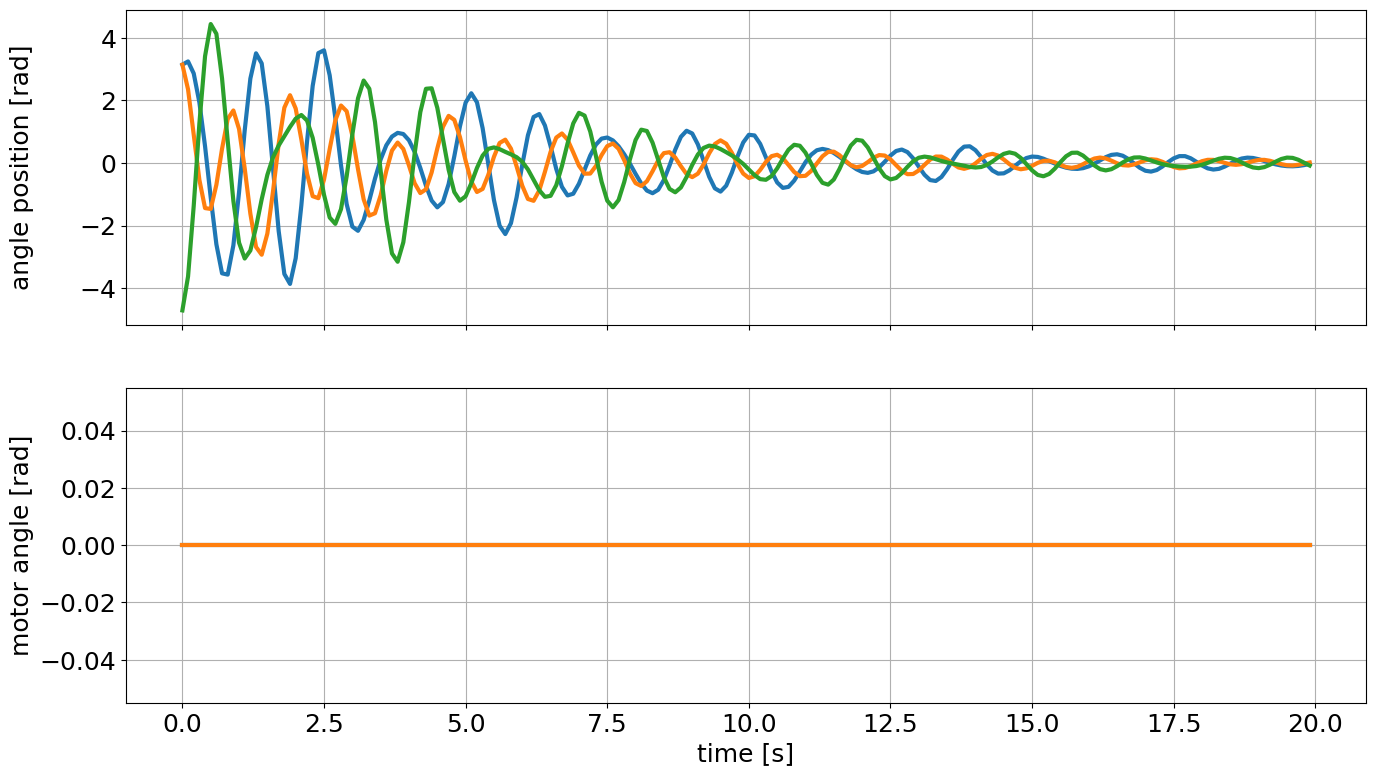

In [87]:
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
# Show the figure:
fig

## Optimization

In [88]:
u0 = mpc.make_step(x0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    19448
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1229

Total number of variables............................:     6408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2412
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5768
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.8086219e+02 1.65e+01 1.07e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [89]:
sim_graphics.clear()

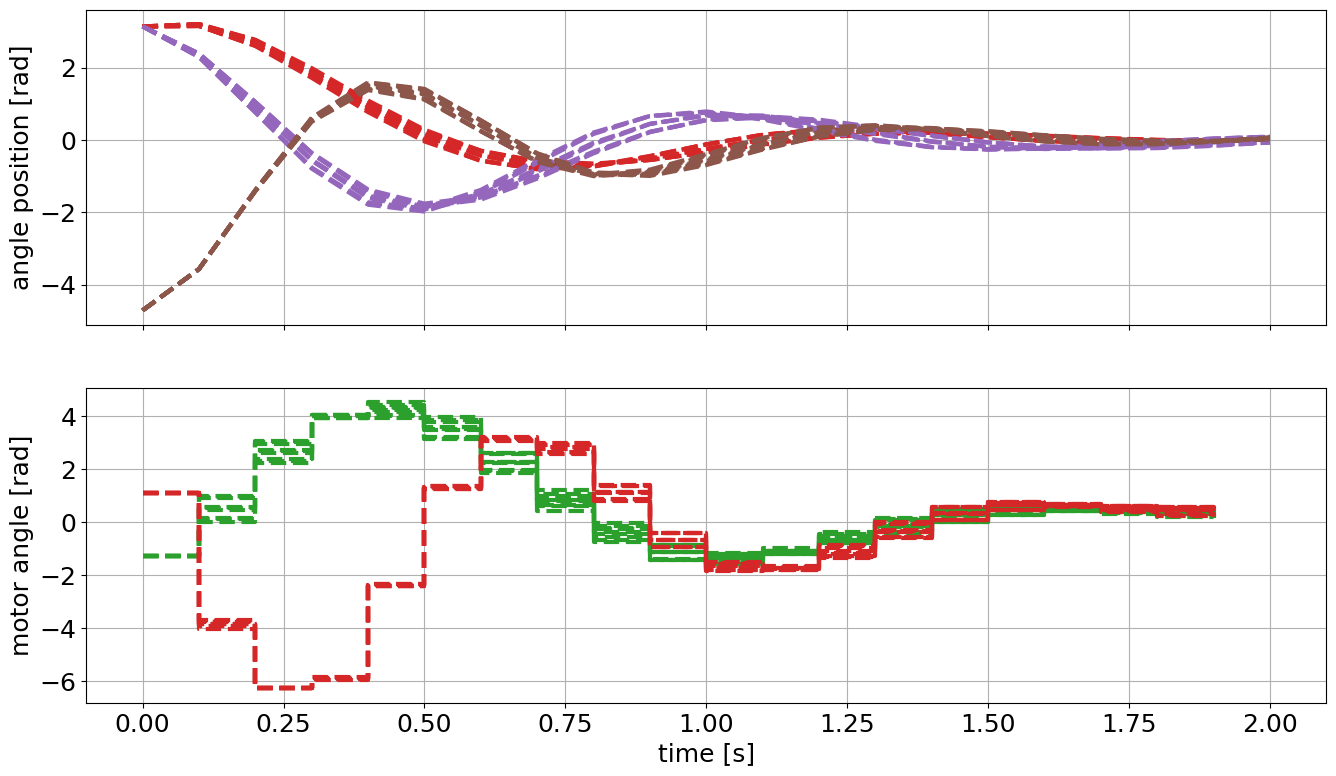

In [90]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig